In [1]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [3]:
#filtering 2023 player data
df_2023 = nfl.import_weekly_data([2023])
columns_to_keep  = ['player_id', 'player_name', 'position', 'position_group', 'season', 'week', 
                   'passing_yards', 'passing_tds', 'interceptions', 'passing_air_yards',
                   'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
                   'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds', 
                   'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 
                   'rushing_2pt_conversions', 'receiving_fumbles_lost', 'receiving_air_yards',
                   'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 
                   'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
                   'fantasy_points_ppr', 'receptions', 'targets', 'receiving_yards', 
                   'receiving_tds']

filtered1_df_2023 = df_2023[columns_to_keep]

Downcasting floats.


In [5]:
#Finding each players average PPG in 2022 
df_2022 = nfl.import_weekly_data([2022])
filtered_df_2022 = df_2022[columns_to_keep]
average_fantasy_points_df_2022 = filtered_df_2022.groupby(['player_id', 'player_name', 'position', 'position_group'], as_index=False)['fantasy_points_ppr'].mean()
average_fantasy_points_df_2022.rename(columns={'fantasy_points_ppr': 'avg_fantasy_points_ppr'}, inplace=True)

Downcasting floats.


In [7]:
#merging the dataframes to put the 2022 averages in with the 2023 week by week data
average_fantasy_points_df_2022 = filtered_df_2022.groupby(['player_id'], as_index=False)['fantasy_points_ppr'].mean()
average_fantasy_points_df_2022.rename(columns={'fantasy_points_ppr': 'avg_fantasy_points_ppr'}, inplace=True)
merged_df = pd.merge(filtered1_df_2023, average_fantasy_points_df_2022, on='player_id', how='left')
merged_df['avg_fantasy_points_ppr'].fillna(0, inplace=True)
#print(merged_df)


In [9]:
#Creating a new column called 'net_points' which that is 'avg_fantasy_points_ppr' from 2022 minus their 'fantasy_points_ppr' for each week of 2203 season called 'net_points'
merged_df['net_points'] = merged_df['avg_fantasy_points_ppr'] - merged_df['fantasy_points_ppr']
#remove all rows where 'avg_fantasy_points_ppr' is equal to 0 (takes out rookies in 2023, injuries, etc.)
merged_df = merged_df[merged_df['avg_fantasy_points_ppr'] != 0]
#print(merged_df[['player_id', 'player_name', 'position', 'week', 'fantasy_points_ppr', 'avg_fantasy_points_ppr', 'net_points']])


In [11]:
# Calculate percent change
merged_df['percent_change'] = ((merged_df['fantasy_points_ppr'] - merged_df['avg_fantasy_points_ppr']) / merged_df['avg_fantasy_points_ppr']) * 100

# Remove rows where avg_fantasy_points_ppr is zero to avoid division by zero
merged_df = merged_df[merged_df['avg_fantasy_points_ppr'] != 0]

# Display the relevant columns with the new percent_change column
print(merged_df[['player_id', 'player_name', 'position', 'week', 'fantasy_points_ppr', 'avg_fantasy_points_ppr', 'percent_change']].head())


    player_id player_name position  week  fantasy_points_ppr  \
0  00-0023459   A.Rodgers       QB     1                 0.0   
1  00-0024243     M.Lewis       TE     4                 1.8   
2  00-0024243     M.Lewis       TE     7                 2.6   
3  00-0024243     M.Lewis       TE    11                 0.0   
4  00-0024243     M.Lewis       TE    14                 1.4   

   avg_fantasy_points_ppr  percent_change  
0               14.070588     -100.000000  
1                4.433333      -59.398495  
2                4.433333      -41.353386  
3                4.433333     -100.000000  
4                4.433333      -68.421051  


In [13]:
import pandas as pd

# Assume 'merged_df' has been calculated and 'percent_change' is already computed
# Now, calculate streaks for different lengths of weeks

def find_players_with_streaks(min_weeks=3, max_weeks=17):
    streak_data = []

    # Iterate over streak lengths (3, 4, 5, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        # Group by player_id to handle each player individually
        for player_id, player_data in merged_df.groupby('player_id'):
            player_name = player_data['player_name'].iloc[0]
            position = player_data['position'].iloc[0]
            avg_2022_points = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Sort player data by week to calculate rolling averages
            player_data = player_data.sort_values(by='week').reset_index(drop=True)

            # Calculate rolling average of fantasy points over the given streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            # Find streaks where rolling average is 33% higher than 2022 average points
            qualifying_streaks = player_data[player_data['rolling_avg'] > avg_2022_points * 1.33]

            # Check if there are any valid streaks of this length
            if len(qualifying_streaks) >= streak_length:
                streak_data.append({
                    'player_id': player_id,
                    'player_name': player_name,
                    'position': position,
                    'streak_length': streak_length,
                    'weeks': list(qualifying_streaks['week']),
                    'rolling_avg': qualifying_streaks['rolling_avg'].iloc[-1]
                })

    return pd.DataFrame(streak_data)

# Find players with streaks of 33% increase for different lengths of weeks (3 to 17)
streaks_df = find_players_with_streaks()

# Display the resulting DataFrame of streaks
print(streaks_df)


      player_id player_name position  streak_length  \
0    00-0026158    J.Flacco       QB              3   
1    00-0026498  M.Stafford       QB              3   
2    00-0028118    T.Taylor       QB              3   
3    00-0029892  K.Juszczyk       FB              3   
4    00-0030035   A.Thielen       WR              3   
..          ...         ...      ...            ...   
400  00-0034855  B.Mayfield       QB             10   
401  00-0036264      J.Love       QB             10   
402  00-0037248      J.Cook       RB             10   
403  00-0037256     R.White       RB             10   
404  00-0037834     B.Purdy       QB             10   

                                        weeks  rolling_avg  
0                            [15, 16, 17, 19]    20.353333  
1                    [13, 14, 15, 16, 17, 19]    18.660000  
2                          [7, 8, 15, 17, 18]    15.286667  
3                                 [6, 15, 22]     5.400000  
4                          [3, 4, 

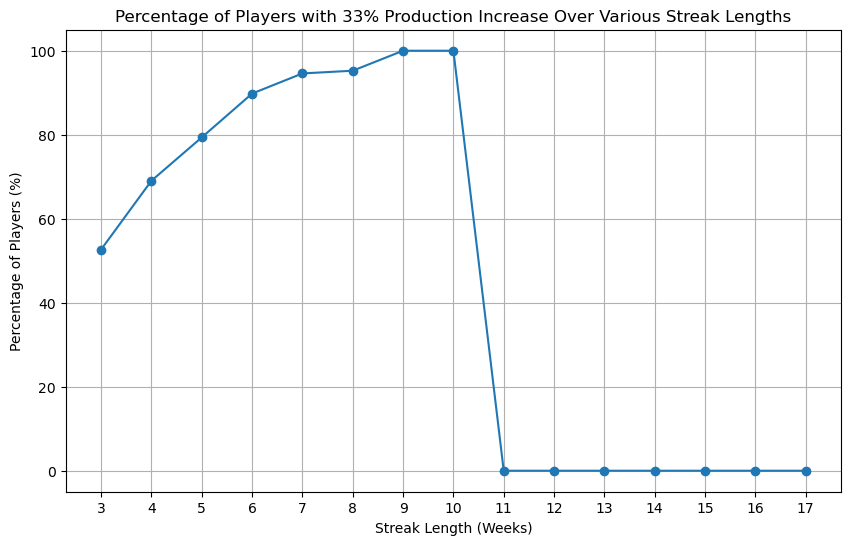

In [14]:
import matplotlib.pyplot as plt

def calculate_percent_of_players_with_streak(streaks_df, min_weeks=3, max_weeks=17):
    percentages = []

    # Iterate over streak lengths (3, 4, 5, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        # Get all players with at least this streak length in the year
        players_with_streak = streaks_df[streaks_df['streak_length'] == streak_length]

        # Count how many players averaged 33% more points over the entire 2023 season
        qualifying_players = 0
        total_players = len(players_with_streak)

        for player_id in players_with_streak['player_id'].unique():
            player_data = merged_df[merged_df['player_id'] == player_id]

            # Calculate average fantasy points for the 2023 season
            avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Check if they averaged 33% more in 2023
            if avg_fantasy_points_2023 > avg_fantasy_points_2022 * 1.33:
                qualifying_players += 1

        # Calculate the percentage of qualifying players
        percentage = (qualifying_players / total_players) * 100 if total_players > 0 else 0
        percentages.append(percentage)

    return percentages

# Calculate the percentage of players for each streak length who meet the 33% increase condition
percentages = calculate_percent_of_players_with_streak(streaks_df)

# Plot the percentages for streaks from 3 to 17 weeks
plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), percentages, marker='o')
plt.title('Percentage of Players with 33% Production Increase Over Various Streak Lengths')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Percentage of Players (%)')
plt.grid(True)
plt.xticks(range(3, 18))
plt.show()


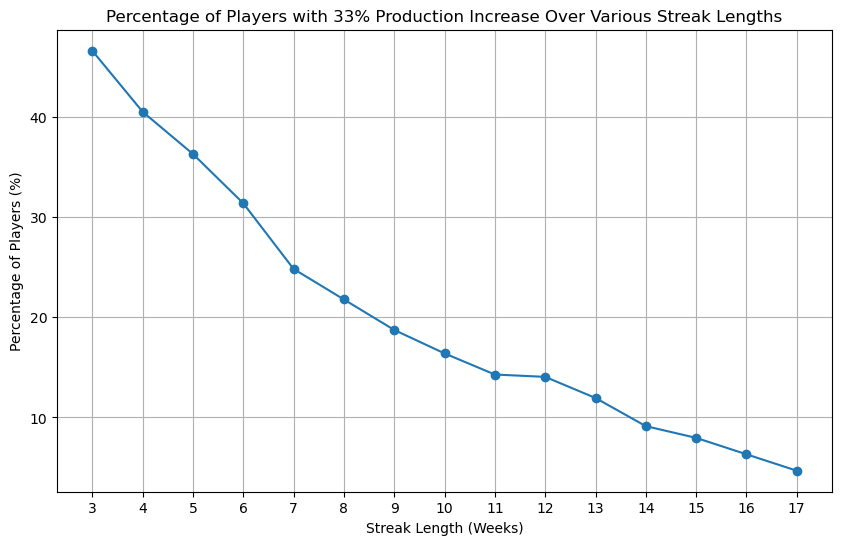

In [16]:
import matplotlib.pyplot as plt

def calculate_percent_of_players_with_streak(merged_df, min_weeks=3, max_weeks=17):
    percentages = []
    
    # Get all unique players
    player_ids = merged_df['player_id'].unique()

    # Iterate over streak lengths (3, 4, 5, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        total_players = 0

        # Loop through each player and calculate their rolling averages
        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            # Check if any of the rolling averages is at least 33% more than their 2022 average
            if (player_data['rolling_avg'] > avg_fantasy_points_2022 * 1.33).any():
                qualifying_players += 1
            total_players += 1

        # Calculate the percentage of qualifying players
        percentage = (qualifying_players / total_players) * 100 if total_players > 0 else 0
        percentages.append(percentage)

    return percentages

# Calculate the percentage of players for each streak length who averaged 33% more fantasy points
percentages = calculate_percent_of_players_with_streak(merged_df)

# Plot the percentages for streaks from 3 to 17 weeks
plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), percentages, marker='o')
plt.title('Percentage of Players with 33% Production Increase Over Various Streak Lengths')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Percentage of Players (%)')
plt.grid(True)
plt.xticks(range(3, 18))
plt.show()


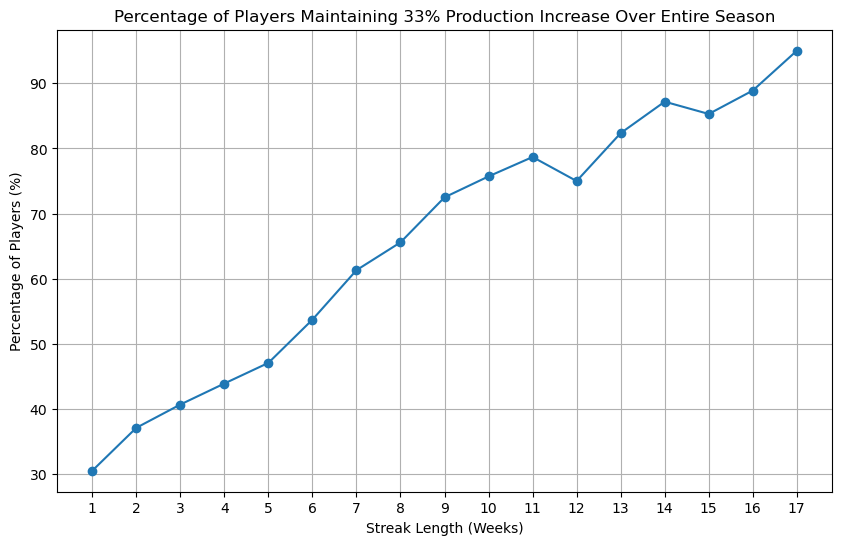

In [18]:
import matplotlib.pyplot as plt
def calculate_streak_continuation(merged_df, min_weeks=1, max_weeks=17):
    streak_continuation_percentages = []
    
    player_ids = merged_df['player_id'].unique()

    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        continued_streak_players = 0

        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            # Check if any of the rolling averages is at least 33% more than their 2022 average
            if (player_data['rolling_avg'] > avg_fantasy_points_2022 * 1.33).any():
                qualifying_players += 1

                # Check if their entire 2023 season average is at least 33% more than their 2022 average
                avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
                if avg_fantasy_points_2023 > avg_fantasy_points_2022 * 1.33:
                    continued_streak_players += 1

        # percentage of players who maintained the 33% increase for the entire season
        percentage = (continued_streak_players / qualifying_players) * 100 if qualifying_players > 0 else 0
        streak_continuation_percentages.append(percentage)

    return streak_continuation_percentages

#  percentage of players who continued their 33% increase streak for the full season
streak_continuation_percentages = calculate_streak_continuation(merged_df)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 18), streak_continuation_percentages, marker='o')
plt.title('Percentage of Players Maintaining 33% Production Increase Over Entire Season')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Percentage of Players (%)')
plt.grid(True)
plt.xticks(range(1, 18))
plt.show()


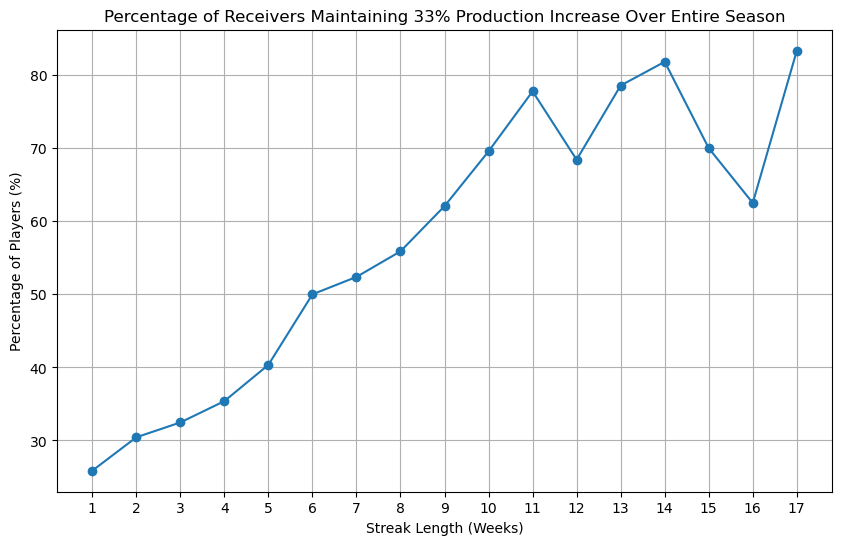

In [21]:
#only wr for less variance: 
import matplotlib.pyplot as plt

def calculate_streak_continuation_for_receivers(merged_df, min_weeks=1, max_weeks=17):
    streak_continuation_percentages = []
    
    # Filter the merged_df to only include wide receivers (WR)
    receivers_df = merged_df[merged_df['position'] == 'WR']
    
    # Get all unique wide receiver players
    player_ids = receivers_df['player_id'].unique()

    # Iterate over streak lengths (1, 2, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        continued_streak_players = 0

        # Loop through each receiver and calculate their rolling averages
        for player_id in player_ids:
            player_data = receivers_df[receivers_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            # Check if any of the rolling averages is at least 33% more than their 2022 average
            if (player_data['rolling_avg'] > avg_fantasy_points_2022 * 1.33).any():
                qualifying_players += 1

                # Check if their entire 2023 season average is at least 33% more than their 2022 average
                avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
                if avg_fantasy_points_2023 > avg_fantasy_points_2022 * 1.33:
                    continued_streak_players += 1

        # Calculate the percentage of wide receivers who maintained the 33% increase for the entire season
        percentage = (continued_streak_players / qualifying_players) * 100 if qualifying_players > 0 else 0
        streak_continuation_percentages.append(percentage)

    return streak_continuation_percentages

# Calculate the percentage of receivers who continued their 33% increase streak for the full season
streak_continuation_percentages_for_receivers = calculate_streak_continuation_for_receivers(merged_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 18), streak_continuation_percentages_for_receivers, marker='o')
plt.title('Percentage of Receivers Maintaining 33% Production Increase Over Entire Season')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Percentage of Players (%)')
plt.grid(True)
plt.xticks(range(1, 18))
plt.show()


In [23]:
# Extract data for weeks 12 and 16
weeks_12_16_df = merged_df[(merged_df['week'].isin([12, 16])) & (merged_df['position'] == 'WR')]

# Group by week to summarize the data for these weeks
week_summary = weeks_12_16_df.groupby('week').agg({
    'fantasy_points_ppr': ['mean', 'median', 'min', 'max', 'std', 'count'],
    'player_id': 'nunique'
}).reset_index()

# Display the summary for weeks 12 and 16
print(week_summary)


  week fantasy_points_ppr                                   player_id
                     mean median  min   max       std count   nunique
0   12           8.312745   6.65  0.0  25.4  7.125476   102       102
1   16           9.420000   7.10  0.0  51.5  9.204562    95        95


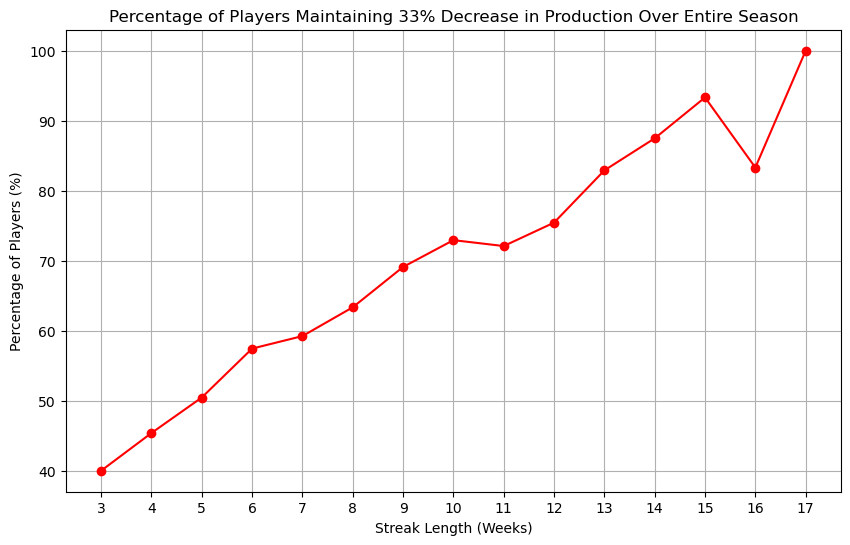

In [25]:
import matplotlib.pyplot as plt

def calculate_streak_continuation_for_decrease(merged_df, min_weeks=3, max_weeks=17):
    streak_continuation_percentages = []
    
    # Get all unique players
    player_ids = merged_df['player_id'].unique()

    # Iterate over streak lengths (3, 4, 5, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        continued_streak_players = 0

        # Loop through each player and calculate their rolling averages
        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            # Check if any of the rolling averages is at least 33% less than their 2022 average (i.e., less than 67% of their 2022 average)
            if (player_data['rolling_avg'] < avg_fantasy_points_2022 * 0.67).any():
                qualifying_players += 1

                # Check if their entire 2023 season average is at least 33% less than their 2022 average
                avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
                if avg_fantasy_points_2023 < avg_fantasy_points_2022 * 0.67:
                    continued_streak_players += 1

        # Calculate the percentage of players who maintained the 33% decrease for the entire season
        percentage = (continued_streak_players / qualifying_players) * 100 if qualifying_players > 0 else 0
        streak_continuation_percentages.append(percentage)

    return streak_continuation_percentages

# Calculate the percentage of players who continued their 33% decrease streak for the full season
streak_continuation_percentages_for_decrease = calculate_streak_continuation_for_decrease(merged_df)

# Plot the percentages for streaks from 3 to 17 weeks
plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), streak_continuation_percentages_for_decrease, marker='o', color='red')
plt.title('Percentage of Players Maintaining 33% Decrease in Production Over Entire Season')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Percentage of Players (%)')
plt.grid(True)
plt.xticks(range(3, 18))
plt.show()


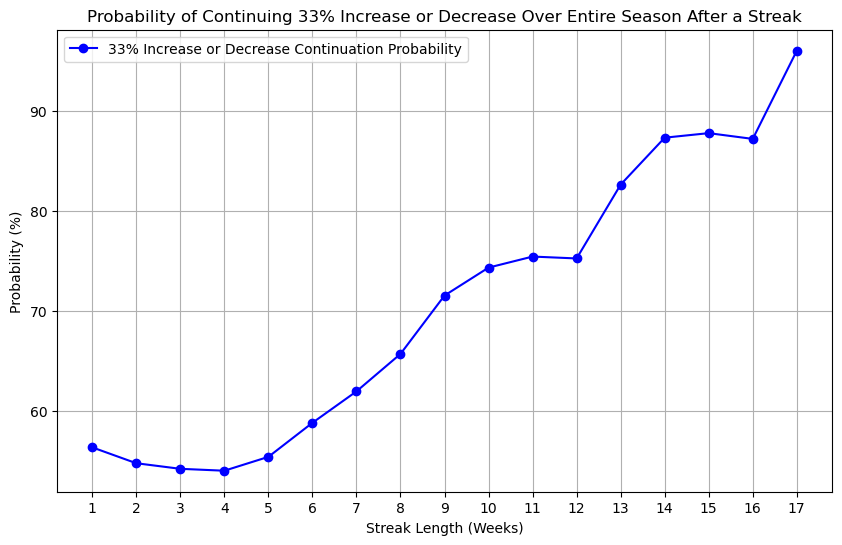

In [26]:
import matplotlib.pyplot as plt

def calculate_combined_streak_probabilities(merged_df, min_weeks=1, max_weeks=17):
    combined_probabilities = []
    
    player_ids = merged_df['player_id'].unique()

    # Iterate over streak lengths (1, 2, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        continued_streak_players = 0

        # Loop through each player and calculate their rolling averages
        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            # Check for both increase and decrease conditions
            increase_condition = player_data['rolling_avg'] > avg_fantasy_points_2022 * 1.33
            decrease_condition = player_data['rolling_avg'] < avg_fantasy_points_2022 * 0.67

            if increase_condition.any() or decrease_condition.any():
                qualifying_players += 1

                # Check if the player maintains either the increase or decrease for the entire season
                avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
                if avg_fantasy_points_2023 > avg_fantasy_points_2022 * 1.33 or avg_fantasy_points_2023 < avg_fantasy_points_2022 * 0.67:
                    continued_streak_players += 1

        # Calculate the combined probability for this streak length
        probability = (continued_streak_players / qualifying_players) * 100 if qualifying_players > 0 else 0
        combined_probabilities.append(probability)

    return combined_probabilities

# Calculate the combined probabilities for increase or decrease
combined_probabilities = calculate_combined_streak_probabilities(merged_df)

# Plot the combined probability distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 18), combined_probabilities, marker='o', color='blue', label='33% Increase or Decrease Continuation Probability')

# Add labels, title, and legend
plt.title('Probability of Continuing 33% Increase or Decrease Over Entire Season After a Streak')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Probability (%)')
plt.grid(True)
plt.xticks(range(1, 18))
plt.legend()

# Display the plot
plt.show()


In [29]:
def calculate_streak_continuation_for_decrease(merged_df, min_weeks=3, max_weeks=17):
    streak_continuation_percentages = []
    players_with_long_streaks = {15: [], 16: [], 17: []}  # Dictionary to hold players with streaks of 15, 16, 17 weeks
    
    # Get all unique players
    player_ids = merged_df['player_id'].unique()

    # Iterate over streak lengths (3, 4, 5, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        continued_streak_players = 0

        # Loop through each player and calculate their rolling averages
        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]
            player_name = player_data['player_name'].iloc[0]  # Get the player name

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            # Check if any of the rolling averages is at least 33% less than their 2022 average (i.e., less than 67% of their 2022 average)
            if (player_data['rolling_avg'] < avg_fantasy_points_2022 * 0.67).any():
                qualifying_players += 1

                # Check if their entire 2023 season average is at least 33% less than their 2022 average
                avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
                if avg_fantasy_points_2023 < avg_fantasy_points_2022 * 0.67:
                    continued_streak_players += 1

                    # If the streak length is 15, 16, or 17 weeks, add the player name and ID to the list
                    if streak_length in players_with_long_streaks:
                        players_with_long_streaks[streak_length].append((player_name, player_id))

        # Calculate the percentage of players who maintained the 33% decrease for the entire season
        percentage = (continued_streak_players / qualifying_players) * 100 if qualifying_players > 0 else 0
        streak_continuation_percentages.append(percentage)

    return streak_continuation_percentages, players_with_long_streaks

# Calculate the percentage of players and list of players for specific streak lengths
streak_continuation_percentages_for_decrease, players_with_long_streaks = calculate_streak_continuation_for_decrease(merged_df)

# Output the players with streaks of 15, 16, and 17 weeks along with their names
players_with_long_streaks_15_16_17 = {
    '15_week_streak': players_with_long_streaks[15],
    '16_week_streak': players_with_long_streaks[16],
    '17_week_streak': players_with_long_streaks[17]
}

players_with_long_streaks_15_16_17


{'15_week_streak': [('L.Murray', '00-0030513'),
  ('A.Robinson', '00-0031428'),
  ('A.Abdullah', '00-0032104'),
  ('A.Hooper', '00-0032392'),
  ('C.Moore', '00-0032398'),
  ('D.Cook', '00-0033893'),
  ('M.Valdes-Scantling', '00-0034272'),
  ('C.Edmonds', '00-0034681'),
  ('M.Sanders', '00-0035243'),
  ('C.Edwards-Helaire', '00-0036360'),
  ('J.Jeudy', '00-0036407'),
  ('R.Bateman', '00-0036550'),
  ('M.Carter', '00-0036924'),
  ('R.Moore', '00-0036936')],
 '16_week_streak': [('L.Murray', '00-0030513'),
  ('A.Robinson', '00-0031428'),
  ('A.Abdullah', '00-0032104'),
  ('A.Hooper', '00-0032392'),
  ('M.Valdes-Scantling', '00-0034272'),
  ('M.Sanders', '00-0035243'),
  ('C.Edwards-Helaire', '00-0036360'),
  ('J.Jeudy', '00-0036407'),
  ('R.Bateman', '00-0036550'),
  ('R.Moore', '00-0036936')],
 '17_week_streak': [('L.Murray', '00-0030513'),
  ('M.Valdes-Scantling', '00-0034272'),
  ('C.Edwards-Helaire', '00-0036360'),
  ('R.Bateman', '00-0036550'),
  ('R.Moore', '00-0036936')]}

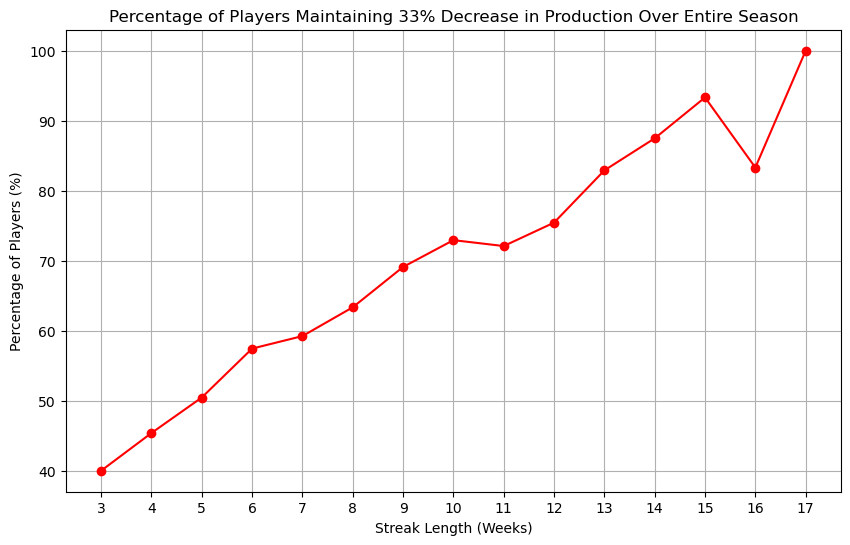

In [30]:
import matplotlib.pyplot as plt

def calculate_streak_continuation_for_decrease_fixed(merged_df, min_weeks=3, max_weeks=17):
    streak_continuation_percentages = []
    players_with_long_streaks = {15: [], 16: [], 17: []}  # Dictionary to hold players with streaks of 15, 16, 17 weeks
    
    # Get all unique players
    player_ids = merged_df['player_id'].unique()

    # Iterate over streak lengths (3, 4, 5, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        continued_streak_players = 0

        # Loop through each player and calculate their rolling averages
        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]
            player_name = player_data['player_name'].iloc[0]  # Get the player name

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length, min_periods=streak_length).mean()

            # Ensure we only consider players with enough weeks of data for the streak length
            if player_data['rolling_avg'].isna().all():
                continue  # Skip players without enough data for the streak length

            # Check if any of the rolling averages is at least 33% less than their 2022 average (i.e., less than 67% of their 2022 average)
            if (player_data['rolling_avg'] < avg_fantasy_points_2022 * 0.67).any():
                qualifying_players += 1

                # Check if their entire 2023 season average is at least 33% less than their 2022 average
                avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
                if avg_fantasy_points_2023 < avg_fantasy_points_2022 * 0.67:
                    continued_streak_players += 1

                    # If the streak length is 15, 16, or 17 weeks, add the player name and ID to the list
                    if streak_length in players_with_long_streaks:
                        players_with_long_streaks[streak_length].append((player_name, player_id))

        # Calculate the percentage of players who maintained the 33% decrease for the entire season
        percentage = (continued_streak_players / qualifying_players) * 100 if qualifying_players > 0 else 0
        streak_continuation_percentages.append(percentage)

    return streak_continuation_percentages, players_with_long_streaks

# Calculate the percentage of players and list of players for specific streak lengths
streak_continuation_percentages_for_decrease_fixed, players_with_long_streaks_fixed = calculate_streak_continuation_for_decrease_fixed(merged_df)

# Plot the percentages for streaks from 3 to 17 weeks
plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), streak_continuation_percentages_for_decrease_fixed, marker='o', color='red')
plt.title('Percentage of Players Maintaining 33% Decrease in Production Over Entire Season')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Percentage of Players (%)')
plt.grid(True)
plt.xticks(range(3, 18))
plt.show()


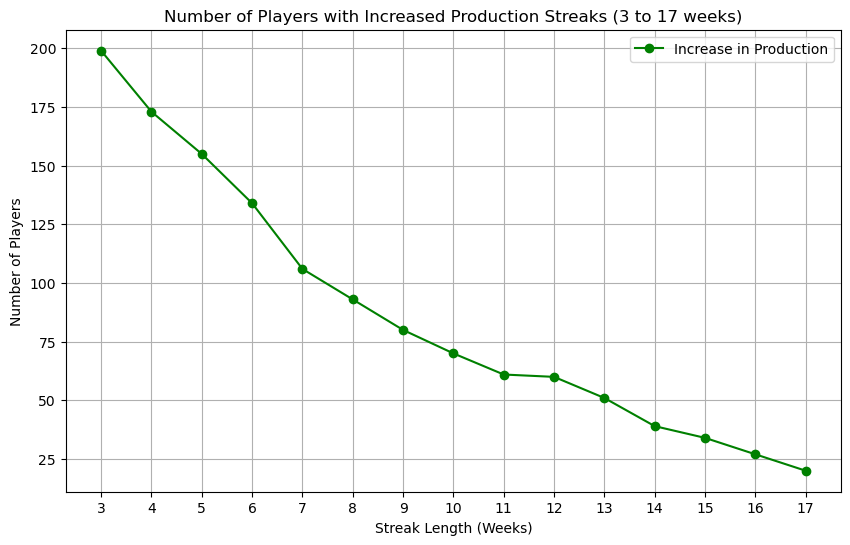

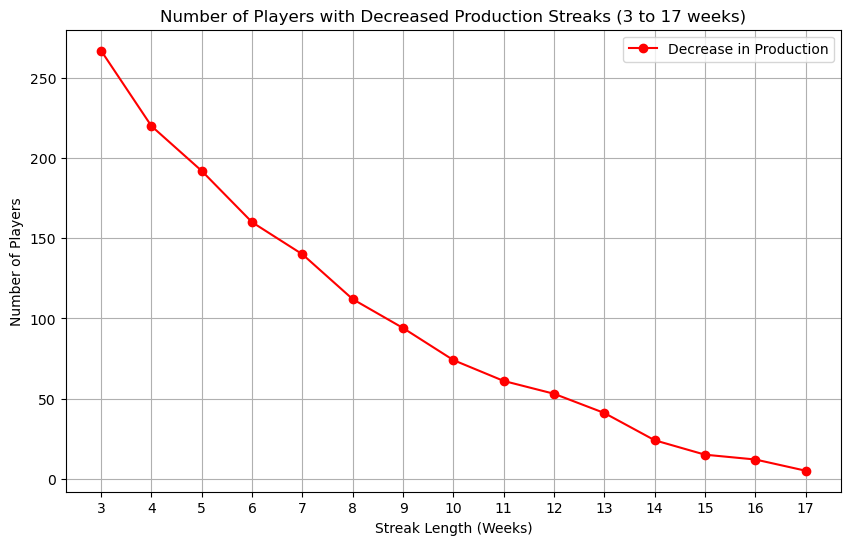

In [65]:
import matplotlib.pyplot as plt

def count_streaks_for_increase_and_decrease(merged_df, min_weeks=3, max_weeks=17):
    streak_counts_increase = []
    streak_counts_decrease = []
    
    # Get all unique players
    player_ids = merged_df['player_id'].unique()

    # Iterate over streak lengths (5, 6, 7, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        count_increase = 0
        count_decrease = 0

        # Loop through each player and calculate their rolling averages
        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length, min_periods=streak_length).mean()

            # Ensure we only consider players with enough weeks of data for the streak length
            if player_data['rolling_avg'].isna().all():
                continue  # Skip players without enough data for the streak length

            # Check for increase: rolling average is at least 33% higher than 2022 average (i.e., greater than 133% of their 2022 average)
            if (player_data['rolling_avg'] > avg_fantasy_points_2022 * 1.33).any():
                count_increase += 1

            # Check for decrease: rolling average is at least 33% less than 2022 average (i.e., less than 67% of their 2022 average)
            if (player_data['rolling_avg'] < avg_fantasy_points_2022 * 0.67).any():
                count_decrease += 1

        streak_counts_increase.append(count_increase)
        streak_counts_decrease.append(count_decrease)

    return streak_counts_increase, streak_counts_decrease

# Calculate the number of players with a streak of increased and decreased production
streak_counts_increase, streak_counts_decrease = count_streaks_for_increase_and_decrease(merged_df)

# Plot the number of players with increased production streaks (3 to 17 weeks)
plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), streak_counts_increase, marker='o', color='green', label='Increase in Production')
plt.title('Number of Players with Increased Production Streaks (3 to 17 weeks)')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Number of Players')
plt.grid(True)
plt.xticks(range(3, 18))
plt.legend()
plt.show()

# Plot the number of players with decreased production streaks (3 to 17 weeks)
plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), streak_counts_decrease, marker='o', color='red', label='Decrease in Production')
plt.title('Number of Players with Decreased Production Streaks (3 to 17 weeks)')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Number of Players')
plt.grid(True)
plt.xticks(range(3, 18))
plt.legend()
plt.show()


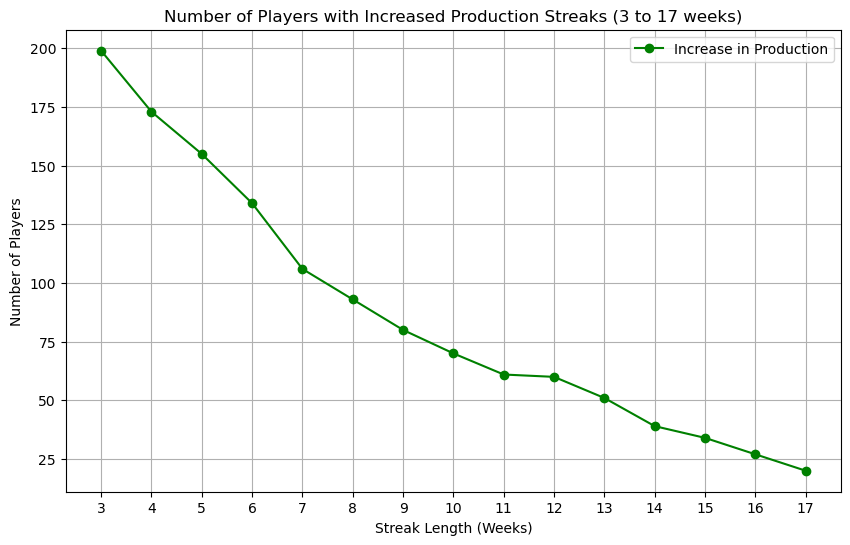

In [67]:
# Plot the number of players with increased production streaks (3 to 17 weeks)
plt.figure(figsize=(10, 6))
plt.plot(range(3, 18), streak_counts_increase, marker='o', color='green', label='Increase in Production')
plt.title('Number of Players with Increased Production Streaks (3 to 17 weeks)')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Number of Players')
plt.grid(True)
plt.xticks(range(3, 18))
plt.legend()
plt.show()

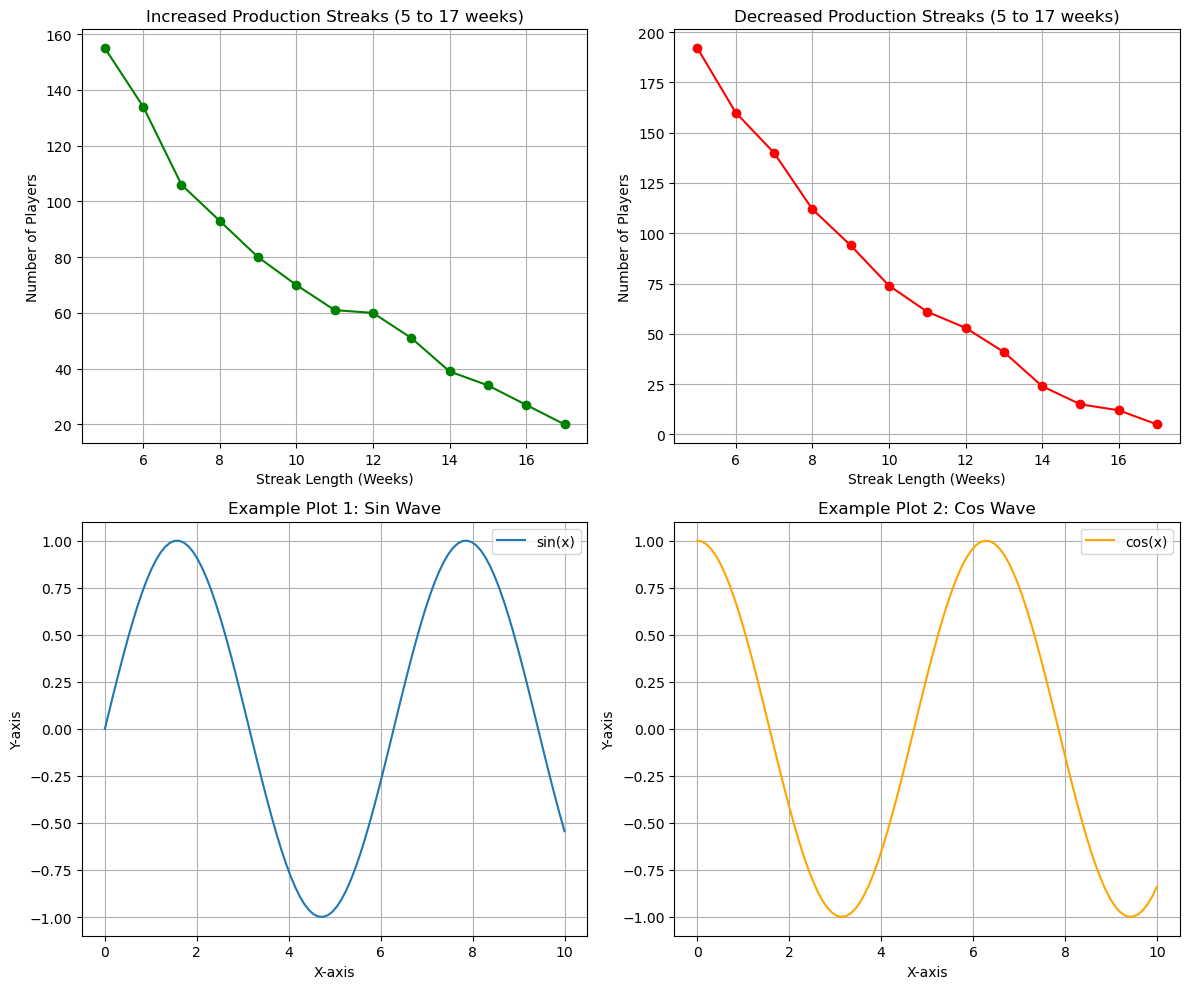

In [35]:
import matplotlib.pyplot as plt

def count_streaks_for_increase_and_decrease(merged_df, min_weeks=5, max_weeks=17):
    streak_counts_increase = []
    streak_counts_decrease = []
    
    # Get all unique players
    player_ids = merged_df['player_id'].unique()

    # Iterate over streak lengths (5, 6, 7, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        count_increase = 0
        count_decrease = 0

        # Loop through each player and calculate their rolling averages
        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length, min_periods=streak_length).mean()

            # Ensure we only consider players with enough weeks of data for the streak length
            if player_data['rolling_avg'].isna().all():
                continue  # Skip players without enough data for the streak length

            # Check for increase: rolling average is at least 33% higher than 2022 average (i.e., greater than 133% of their 2022 average)
            if (player_data['rolling_avg'] > avg_fantasy_points_2022 * 1.33).any():
                count_increase += 1

            # Check for decrease: rolling average is at least 33% less than 2022 average (i.e., less than 67% of their 2022 average)
            if (player_data['rolling_avg'] < avg_fantasy_points_2022 * 0.67).any():
                count_decrease += 1

        streak_counts_increase.append(count_increase)
        streak_counts_decrease.append(count_decrease)

    return streak_counts_increase, streak_counts_decrease

# Calculate the number of players with a streak of increased and decreased production
streak_counts_increase, streak_counts_decrease = count_streaks_for_increase_and_decrease(merged_df)

# Create a single figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid

# Plot the number of players with increased production streaks (5 to 17 weeks)
axes[0, 0].plot(range(5, 18), streak_counts_increase, marker='o', color='green')
axes[0, 0].set_title('Increased Production Streaks (5 to 17 weeks)')
axes[0, 0].set_xlabel('Streak Length (Weeks)')
axes[0, 0].set_ylabel('Number of Players')
axes[0, 0].grid(True)

# Plot the number of players with decreased production streaks (5 to 17 weeks)
axes[0, 1].plot(range(5, 18), streak_counts_decrease, marker='o', color='red')
axes[0, 1].set_title('Decreased Production Streaks (5 to 17 weeks)')
axes[0, 1].set_xlabel('Streak Length (Weeks)')
axes[0, 1].set_ylabel('Number of Players')
axes[0, 1].grid(True)

# Add additional plots as needed in the remaining slots
# Example: Adding some dummy plots (these can be replaced with other meaningful charts)
import numpy as np
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Example plot 1 (sin wave)
axes[1, 0].plot(x, y, label='sin(x)')
axes[1, 0].set_title('Example Plot 1: Sin Wave')
axes[1, 0].set_xlabel('X-axis')
axes[1, 0].set_ylabel('Y-axis')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Example plot 2 (cos wave)
axes[1, 1].plot(x, np.cos(x), label='cos(x)', color='orange')
axes[1, 1].set_title('Example Plot 2: Cos Wave')
axes[1, 1].set_xlabel('X-axis')
axes[1, 1].set_ylabel('Y-axis')
axes[1, 1].grid(True)
axes[1, 1].legend()

# Adjust layout to ensure proper spacing
plt.tight_layout()

# Show the combined figure
plt.show()

# Save the figure to a file for printing
fig.savefig('combined_plots_canvas.png', dpi=300)  # Save the figure in high resolution


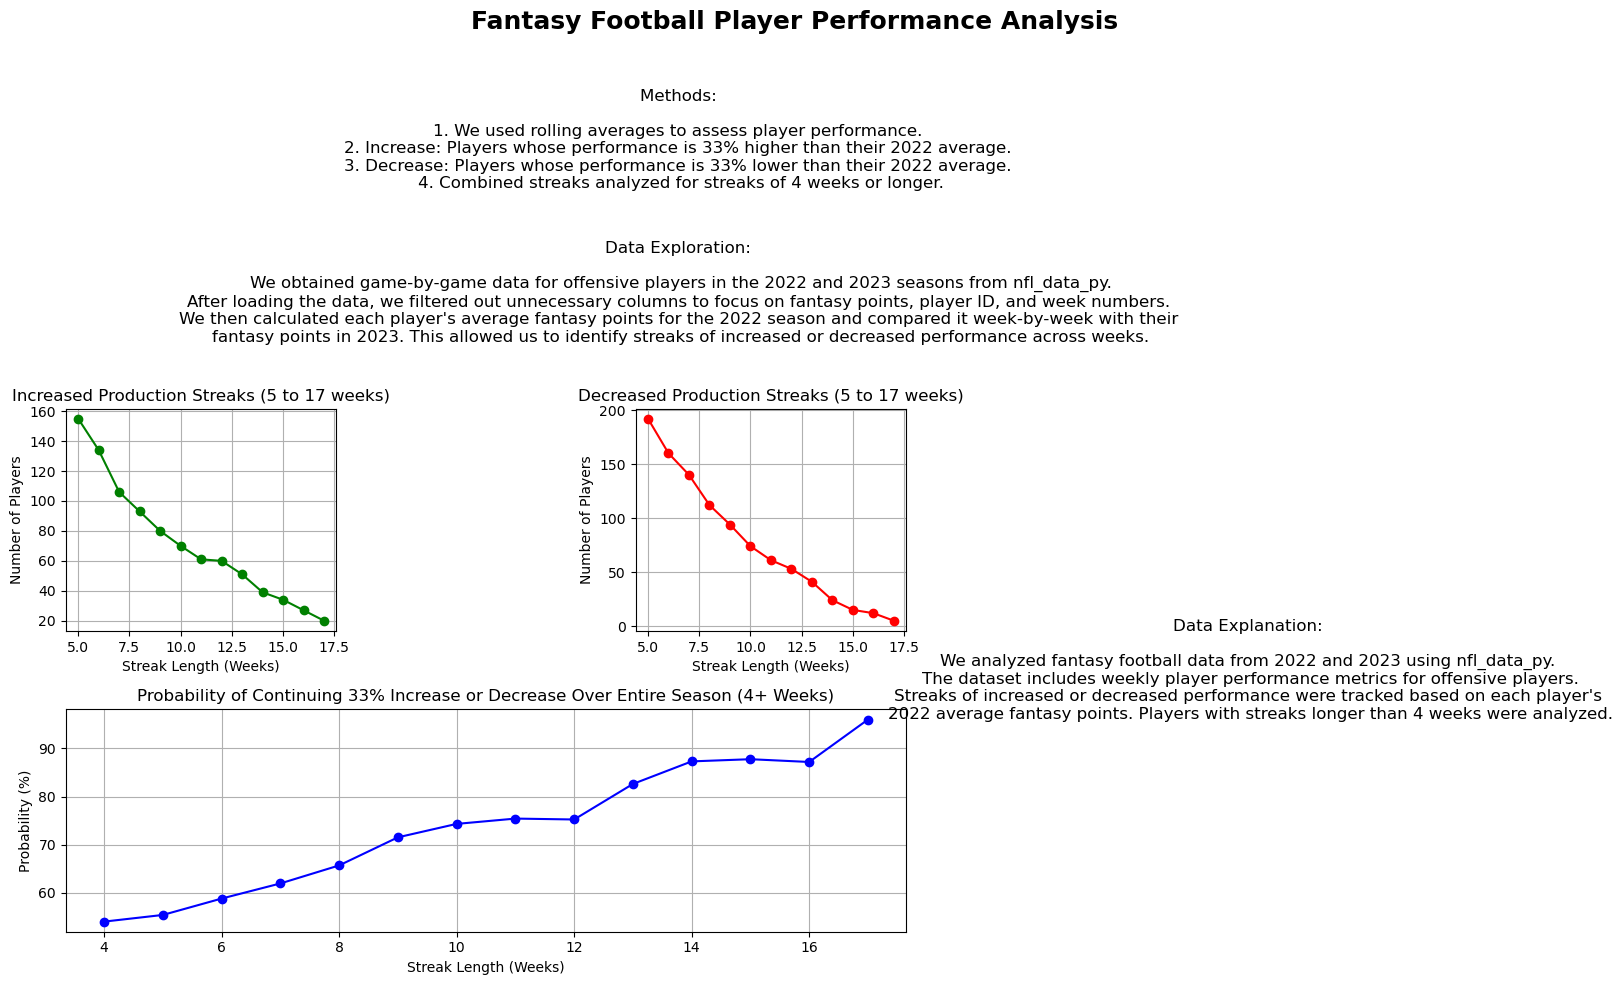

In [37]:
import matplotlib.pyplot as plt

def create_combined_figure(streak_counts_increase, streak_counts_decrease, combined_probabilities):
    fig = plt.figure(figsize=(16, 10))  # Adjust figure size to accommodate text and plots
    
    # Create a grid of 4 rows, 3 columns
    gs = fig.add_gridspec(4, 3, width_ratios=[3, 3, 1], height_ratios=[1, 1, 3, 3])
    
    # Title for the whole figure
    fig.suptitle('Fantasy Football Player Performance Analysis', fontsize=18, fontweight='bold')

    # Top space for methods (Spanning the first row)
    ax_methods = fig.add_subplot(gs[0, :])
    ax_methods.text(0.5, 0.5, 
                    "Methods: \n\n1. We used rolling averages to assess player performance. \n"
                    "2. Increase: Players whose performance is 33% higher than their 2022 average. \n"
                    "3. Decrease: Players whose performance is 33% lower than their 2022 average. \n"
                    "4. Combined streaks analyzed for streaks of 4 weeks or longer.",
                    ha='center', va='center', fontsize=12)
    ax_methods.axis('off')  # Hide axis for text
    
    # Second space for data exploration (Spanning the second row)
    ax_data_exploration = fig.add_subplot(gs[1, :])
    ax_data_exploration.text(0.5, 0.5, 
                    "Data Exploration: \n\nWe obtained game-by-game data for offensive players in the 2022 and 2023 seasons from nfl_data_py.\n"
                    "After loading the data, we filtered out unnecessary columns to focus on fantasy points, player ID, and week numbers. \n"
                    "We then calculated each player's average fantasy points for the 2022 season and compared it week-by-week with their \n"
                    "fantasy points in 2023. This allowed us to identify streaks of increased or decreased performance across weeks.",
                    ha='center', va='center', fontsize=12)
    ax_data_exploration.axis('off')  # Hide axis for text

    # First plot: Number of players with increased production streaks
    ax1 = fig.add_subplot(gs[2, 0])
    ax1.plot(range(5, 18), streak_counts_increase, marker='o', color='green')
    ax1.set_title('Increased Production Streaks (5 to 17 weeks)')
    ax1.set_xlabel('Streak Length (Weeks)')
    ax1.set_ylabel('Number of Players')
    ax1.grid(True)

    # Second plot: Number of players with decreased production streaks
    ax2 = fig.add_subplot(gs[2, 1])
    ax2.plot(range(5, 18), streak_counts_decrease, marker='o', color='red')
    ax2.set_title('Decreased Production Streaks (5 to 17 weeks)')
    ax2.set_xlabel('Streak Length (Weeks)')
    ax2.set_ylabel('Number of Players')
    ax2.grid(True)

    # Third plot: Combined probability for increase or decrease streaks (slice the first 3 values if they exist)
    ax3 = fig.add_subplot(gs[3, 0:2])
    combined_probabilities_filtered = combined_probabilities[3:]  # Start from week 4
    ax3.plot(range(4, 18), combined_probabilities_filtered, marker='o', color='blue')
    ax3.set_title('Probability of Continuing 33% Increase or Decrease Over Entire Season (4+ Weeks)')
    ax3.set_xlabel('Streak Length (Weeks)')
    ax3.set_ylabel('Probability (%)')
    ax3.grid(True)

    # Right side space for data explanations (Spanning the third and fourth rows)
    ax_data_explanation = fig.add_subplot(gs[2:, 2])
    ax_data_explanation.text(0.5, 0.5, 
                             "Data Explanation: \n\nWe analyzed fantasy football data from 2022 and 2023 using nfl_data_py. \n"
                             "The dataset includes weekly player performance metrics for offensive players.\n"
                             "Streaks of increased or decreased performance were tracked based on each player's \n"
                             "2022 average fantasy points. Players with streaks longer than 4 weeks were analyzed.",
                             ha='center', va='center', fontsize=12)
    ax_data_explanation.axis('off')  # Hide axis for text

    # Adjust layout to ensure proper spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()

# Assuming the functions to calculate the streaks have been run and we have the following:
# streak_counts_increase, streak_counts_decrease, combined_probabilities

# Call the function to create the combined figure with text and plots
create_combined_figure(streak_counts_increase, streak_counts_decrease, combined_probabilities)




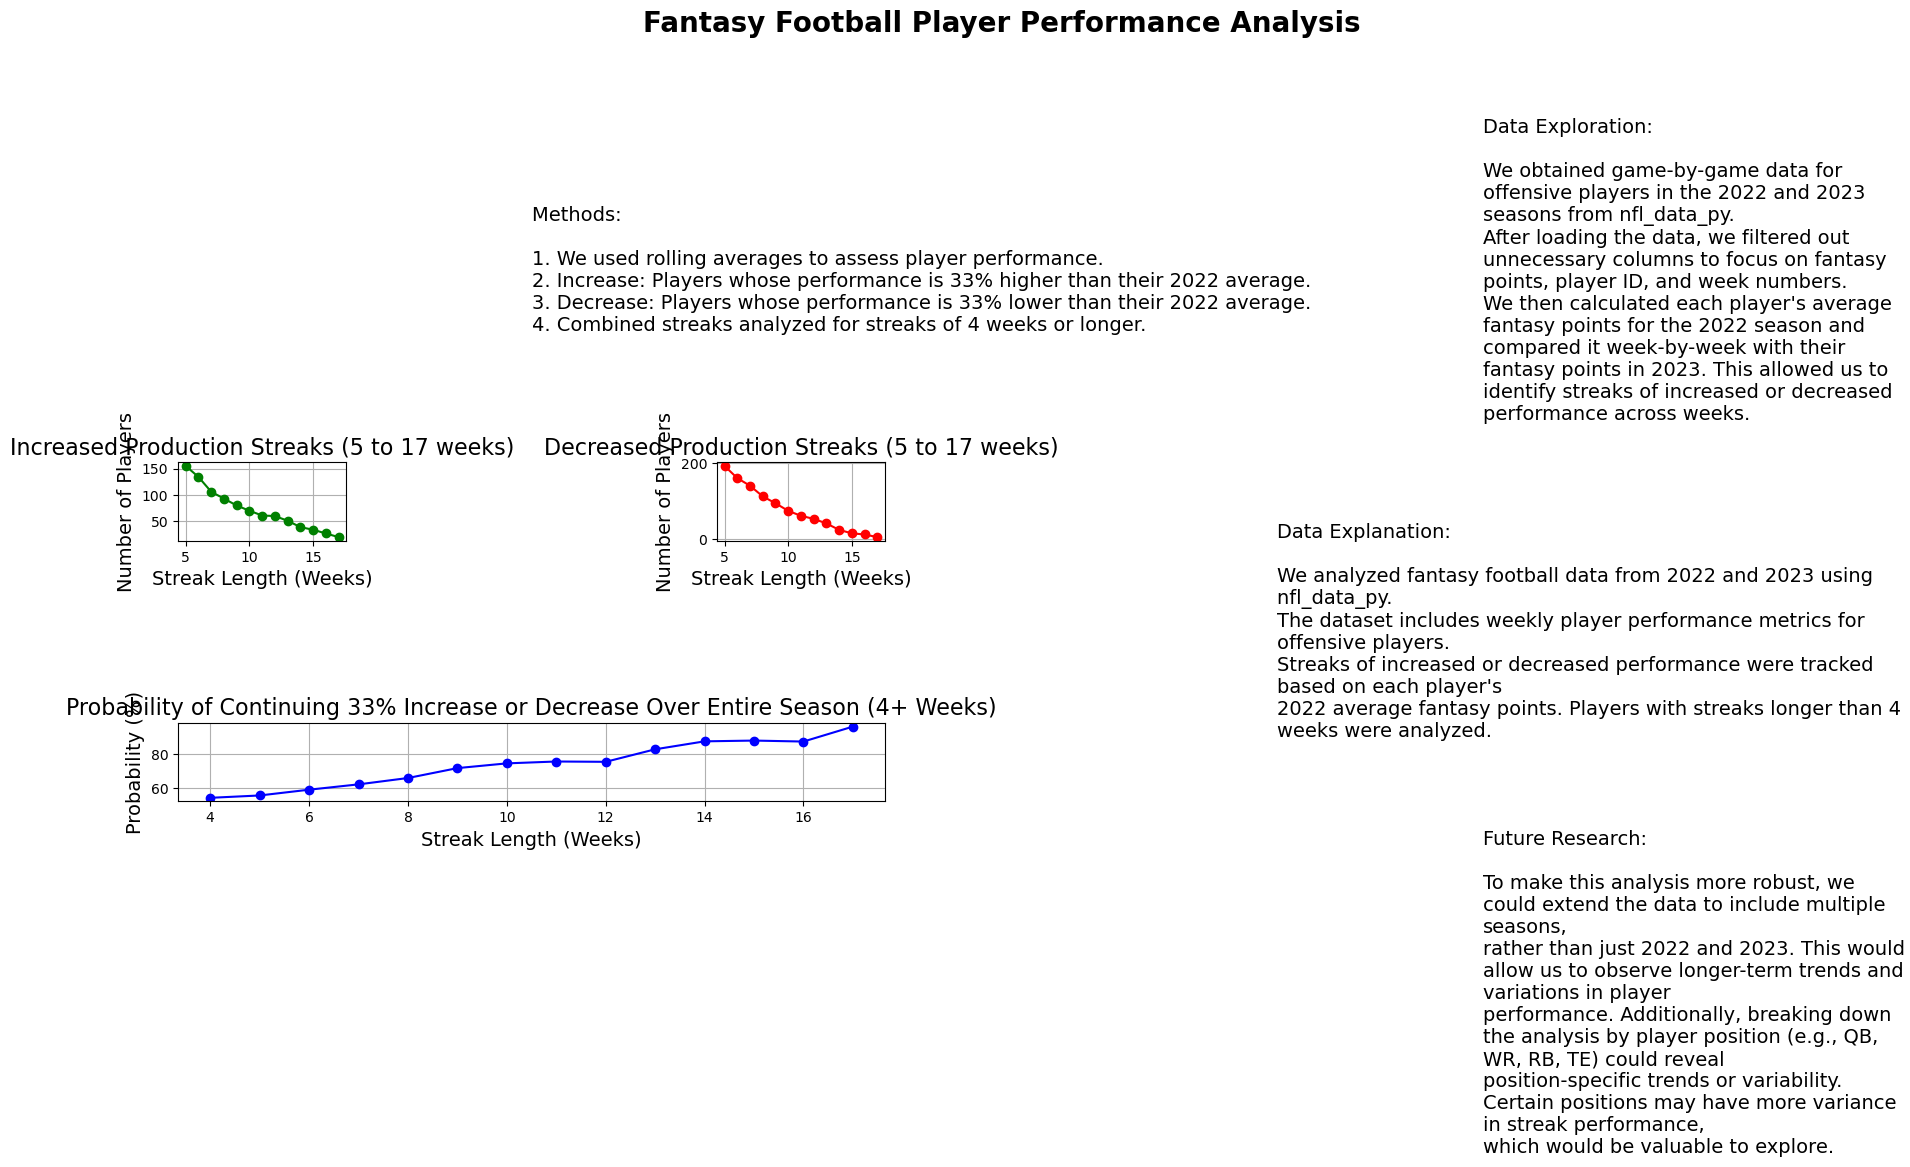

In [39]:
import matplotlib.pyplot as plt

def create_combined_figure(streak_counts_increase, streak_counts_decrease, combined_probabilities):
    fig = plt.figure(figsize=(18, 12))  # Large figure size for bigger plots
    
    # Create a grid of 4 rows, 4 columns (adjusting width and height ratios)
    gs = fig.add_gridspec(4, 4, width_ratios=[4, 4, 1, 1], height_ratios=[1, 4, 4, 1])
    
    # Title for the whole figure
    fig.suptitle('Fantasy Football Player Performance Analysis', fontsize=20, fontweight='bold', y=0.98)

    # Top row for methods (left) and data exploration (right)
    ax_methods = fig.add_subplot(gs[0, 0:2])
    ax_methods.text(0.5, 0.5, 
                    "Methods: \n\n1. We used rolling averages to assess player performance. \n"
                    "2. Increase: Players whose performance is 33% higher than their 2022 average. \n"
                    "3. Decrease: Players whose performance is 33% lower than their 2022 average. \n"
                    "4. Combined streaks analyzed for streaks of 4 weeks or longer.",
                    ha='left', va='center', fontsize=14, wrap=True)
    ax_methods.axis('off')  # Hide axis for text
    
    ax_data_exploration = fig.add_subplot(gs[0, 2:4])
    ax_data_exploration.text(0.5, 0.5, 
                    "Data Exploration: \n\nWe obtained game-by-game data for offensive players in the 2022 and 2023 seasons from nfl_data_py.\n"
                    "After loading the data, we filtered out unnecessary columns to focus on fantasy points, player ID, and week numbers. \n"
                    "We then calculated each player's average fantasy points for the 2022 season and compared it week-by-week with their \n"
                    "fantasy points in 2023. This allowed us to identify streaks of increased or decreased performance across weeks.",
                    ha='left', va='center', fontsize=14, wrap=True)
    ax_data_exploration.axis('off')  # Hide axis for text

    # First plot: Number of players with increased production streaks (larger plot)
    ax1 = fig.add_subplot(gs[1, 0])
    ax1.plot(range(5, 18), streak_counts_increase, marker='o', color='green')
    ax1.set_title('Increased Production Streaks (5 to 17 weeks)', fontsize=16)
    ax1.set_xlabel('Streak Length (Weeks)', fontsize=14)
    ax1.set_ylabel('Number of Players', fontsize=14)
    ax1.grid(True)

    # Second plot: Number of players with decreased production streaks (larger plot)
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.plot(range(5, 18), streak_counts_decrease, marker='o', color='red')
    ax2.set_title('Decreased Production Streaks (5 to 17 weeks)', fontsize=16)
    ax2.set_xlabel('Streak Length (Weeks)', fontsize=14)
    ax2.set_ylabel('Number of Players', fontsize=14)
    ax2.grid(True)

    # Third plot: Combined probability for increase or decrease streaks (larger plot)
    ax3 = fig.add_subplot(gs[2, 0:2])
    combined_probabilities_filtered = combined_probabilities[3:]  # Start from week 4
    ax3.plot(range(4, 18), combined_probabilities_filtered, marker='o', color='blue')
    ax3.set_title('Probability of Continuing 33% Increase or Decrease Over Entire Season (4+ Weeks)', fontsize=16)
    ax3.set_xlabel('Streak Length (Weeks)', fontsize=14)
    ax3.set_ylabel('Probability (%)', fontsize=14)
    ax3.grid(True)

    # Right side space for data explanations (Spanning two rows)
    ax_data_explanation = fig.add_subplot(gs[1:3, 2])
    ax_data_explanation.text(0.5, 0.5, 
                             "Data Explanation: \n\nWe analyzed fantasy football data from 2022 and 2023 using nfl_data_py. \n"
                             "The dataset includes weekly player performance metrics for offensive players.\n"
                             "Streaks of increased or decreased performance were tracked based on each player's \n"
                             "2022 average fantasy points. Players with streaks longer than 4 weeks were analyzed.",
                             ha='left', va='center', fontsize=14, wrap=True)
    ax_data_explanation.axis('off')  # Hide axis for text

    # Bottom-right space for future research
    ax_future_research = fig.add_subplot(gs[3, 2:4])
    ax_future_research.text(0.5, 0.5, 
                            "Future Research: \n\nTo make this analysis more robust, we could extend the data to include multiple seasons,\n"
                            "rather than just 2022 and 2023. This would allow us to observe longer-term trends and variations in player \n"
                            "performance. Additionally, breaking down the analysis by player position (e.g., QB, WR, RB, TE) could reveal\n"
                            "position-specific trends or variability. Certain positions may have more variance in streak performance, \n"
                            "which would be valuable to explore.",
                            ha='left', va='center', fontsize=14, wrap=True)
    ax_future_research.axis('off')  # Hide axis for text

    # Adjust layout to ensure proper spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()

# Assuming the functions to calculate the streaks have been run and we have the following:
# streak_counts_increase, streak_counts_decrease, combined_probabilities

# Call the function to create the combined figure with text and plots
create_combined_figure(streak_counts_increase, streak_counts_decrease, combined_probabilities)


/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg_points) - .5
/var/folders/4d/9v04gb7d0z75_dg3gtdvtnz40000gn/T/ipykernel_8642/4223939573.py:5: RuntimeWarning: invalid value encountered in log
  return 6.9 * np.log(avg

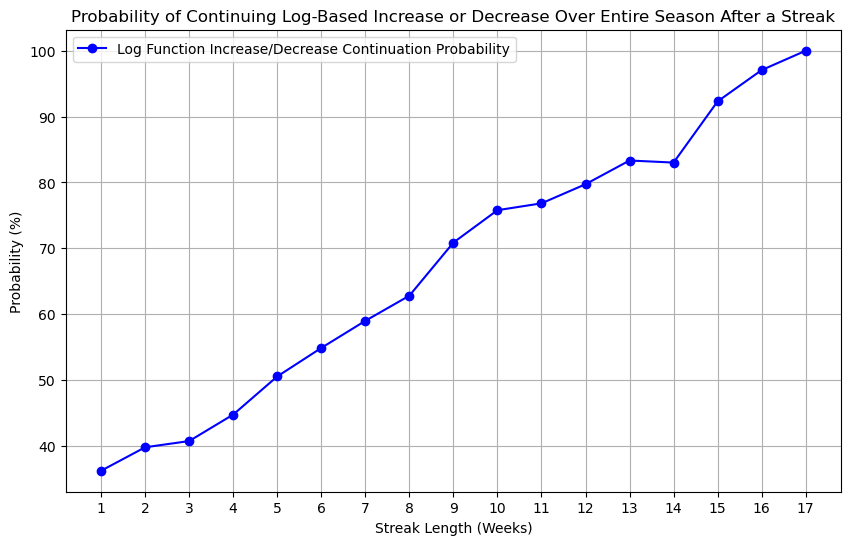

In [41]:
import numpy as np

def log_increase_threshold(avg_points):
    """Applies the log function to calculate the increase threshold."""
    return 6.9 * np.log(avg_points) - .5

def log_decrease_threshold(avg_points):
    """Applies the log function to calculate the decrease threshold (inverse)."""
    return avg_points - (log_increase_threshold(avg_points) - avg_points)

def calculate_combined_streak_probabilities(merged_df, min_weeks=1, max_weeks=17):
    combined_probabilities = []
    
    player_ids = merged_df['player_id'].unique()

    # Iterate over streak lengths (1, 2, ..., 17 weeks)
    for streak_length in range(min_weeks, max_weeks + 1):
        qualifying_players = 0
        continued_streak_players = 0

        # Loop through each player and calculate their rolling averages
        for player_id in player_ids:
            player_data = merged_df[merged_df['player_id'] == player_id].sort_values('week')
            avg_fantasy_points_2022 = player_data['avg_fantasy_points_ppr'].iloc[0]

            # Calculate rolling averages for the current streak length
            player_data['rolling_avg'] = player_data['fantasy_points_ppr'].rolling(window=streak_length).mean()

            # Calculate thresholds using the log function for increase and decrease
            increase_threshold = log_increase_threshold(avg_fantasy_points_2022)
            decrease_threshold = log_decrease_threshold(avg_fantasy_points_2022)

            # Check for both increase and decrease conditions
            increase_condition = player_data['rolling_avg'] > increase_threshold
            decrease_condition = player_data['rolling_avg'] < decrease_threshold

            if increase_condition.any() or decrease_condition.any():
                qualifying_players += 1

                # Check if the player maintains either the increase or decrease for the entire season
                avg_fantasy_points_2023 = player_data['fantasy_points_ppr'].mean()
                if avg_fantasy_points_2023 > increase_threshold or avg_fantasy_points_2023 < decrease_threshold:
                    continued_streak_players += 1

        # Calculate the combined probability for this streak length
        probability = (continued_streak_players / qualifying_players) * 100 if qualifying_players > 0 else 0
        combined_probabilities.append(probability)

    return combined_probabilities

# Calculate the combined probabilities for increase or decrease
combined_probabilities = calculate_combined_streak_probabilities(merged_df)

# Plot the combined probability distribution
plt.figure(figsize=(10, 6))
plt.plot(range(1, 18), combined_probabilities, marker='o', color='blue', label='Log Function Increase/Decrease Continuation Probability')

# Add labels, title, and legend
plt.title('Probability of Continuing Log-Based Increase or Decrease Over Entire Season After a Streak')
plt.xlabel('Streak Length (Weeks)')
plt.ylabel('Probability (%)')
plt.grid(True)
plt.xticks(range(1, 18))
plt.legend()

# Display the plot
plt.show()


In [44]:
combined_probabilities

[36.235955056179776,
 39.795918367346935,
 40.74074074074074,
 44.761904761904766,
 50.54945054945055,
 54.87804878048781,
 58.992805755395686,
 62.8099173553719,
 70.87378640776699,
 75.78947368421053,
 76.82926829268293,
 79.72972972972973,
 83.33333333333334,
 83.01886792452831,
 92.3076923076923,
 97.05882352941177,
 100.0]

In [49]:
combo_prob_df = pd.DataFrame(combined_probabilities, columns=['Probability'])
combo_prob_df

,Probability
0,36.235955
1,39.795918
2,40.740741
3,44.761905
4,50.549451
5,54.878049
6,58.992806
7,62.809917
8,70.873786
9,75.789474


In [77]:
new_row_names = [f'{i+1} Week' for i in range(len(combined_probabilities))]
combo_prob_df.index = new_row_names
combo_prob_df

,Probability
1 Week,36.235955
2 Week,39.795918
3 Week,40.740741
4 Week,44.761905
5 Week,50.549451
6 Week,54.878049
7 Week,58.992806
8 Week,62.809917
9 Week,70.873786
10 Week,75.789474


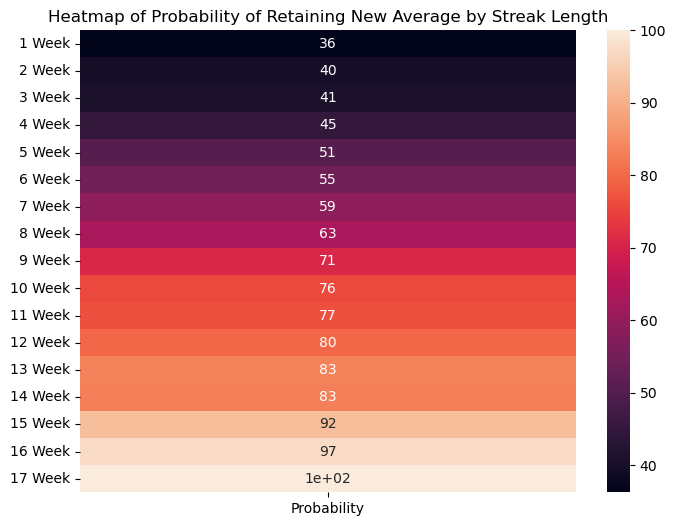

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import dhs_util
from dhs_util import *

plt.figure(figsize=(8, 6))
sns.heatmap(combo_prob_df, annot=True)
plt.title('Heatmap of Probability of Retaining New Average by Streak Length')
plt.show()